**Abstract**: This program uses Regular Expression (`re`) and Natural Language Toolkit (`nltk`) to clean raw post data and collect some features of the data. It uses object-oriented programming (OOP) strategy and creates father class `Data_to_Clean` and derived class `Data_to_Analyze` including various methods to clean and analyze data.

### Import modules and load data

In [22]:
# Import necessary modules

# Module to load raw data(CSV file)
import pandas as pd
import numpy as np

# Modules for NLP
import re # Regular Expression
import string
from typing import List
import nltk # Natural Language Toolkit
from nltk.tokenize import word_tokenize # For text tokenization
from nltk.corpus import wordnet # For stopwords removal
# For tokens part-of-speech tagging and lemmatization
from nltk import pos_tag 
from nltk.stem import WordNetLemmatizer
my_nltk_path="Data"
nltk.data.path.append(my_nltk_path)
import textstat # Evaluate text readability
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Evaluate text emotion
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phrases, Phraser
stop_words=set()
stop_words.update(STOPWORDS)

# Modules to read/write external files,etc.
import json
import pickle
import copy

# Language detection 
import fasttext
lang_model=fasttext.load_model("lid.176.bin")

from tqdm.auto import tqdm
tqdm.pandas()

# Average function
def ave(l):
    return sum(l)/len(l)

# MBTI type dictionary
MBTI_types = [
    'istj', 'isfj', 'infj', 'intj', 
    'istp', 'isfp', 'infp', 'intp', 
    'estp', 'esfp', 'enfp', 'entp', 
    'estj', 'esfj', 'enfj', 'entj'
    ]

# Data loading and spliting 
raw_data=pd.read_csv("Data\\twitter_MBTI.csv",encoding='utf-8')
raw_data.drop(columns="Unnamed: 0",inplace=True)
raw_data.columns=["posts","type"]

In [23]:
raw_data.head(20)

,posts,type
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj
5,Frances Farmer Will Have Her Revenge On Seattl...,intj
6,🤣🤭🤣🤭🤣🤭🤣🤭 https://t.co/2a0tICP1yk|||Blind faith...,intj
7,proud of this one it goes hard https://t.co/RQ...,intj
8,@Ieokuras so amazing!|||@hxhrats @ETTUKILLUG w...,intj
9,@JadMitri Good luck Jad!|||@ElsaYaghi A lawyer...,intj


In [24]:
raw_data["type"].value_counts()

type
infp    1282
infj    1057
intp     811
intj     781
enfp     729
entp     577
enfj     518
isfp     367
isfj     364
istp     327
entj     279
istj     259
esfp     174
esfj     105
estp     100
estj      81
Name: count, dtype: int64

#### Sentence splitting

In [25]:
for i in raw_data.index:
    raw_data.loc[i,"posts"]=raw_data.loc[i,"posts"].split("|||")

### Create a class to clean data

In [26]:
class Data_to_Clean:

    # Load the contraction map in class
    with open(file="contractions.json",mode='r',encoding='utf-8') as f:
        contractions_map=json.load(f)
    def __init__(self,source):
        #self.data should be ALL THE POSTS, type:pd.Series
        self.data=source
    
    # Remove "@Mention" and "#Tag"
    def remove_mention_and_tag(self):
        def process_removal(post):
            post_without_mention=[]
            for sentence in post:
                # Use re to scan and substitute
                post_without_mention.append(
                    re.sub(
                        pattern=r'@\w+|#\w+',
                        repl=' ',
                        string=sentence
                    )
                )
            return post_without_mention
        self.data["posts"]=self.data["posts"].apply(process_removal)
        
    # Remove URL
    def remove_url(self):
        def process_remove_url(post):
            post_without_url=[]
            for sentence in post:
                # Use re to scan and substitute
                post_without_url.append(
                re.sub(
                    pattern=r'http\S+|www\S+|https\S+|\n',
                    repl=' ',
                    string=sentence,
                    flags=re.MULTILINE
                    )
                )
            return post_without_url
        self.data["posts"]=self.data["posts"].apply(process_remove_url)
    
    # Remove emoji
    def remove_emoji(self):
        def process_remove_emoji(post):
            post_without_emoji=[]
            for sentence in post:
                # Use re to scan and substitute
                emoji_pattern=re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
        "\U0001F680-\U0001F6FF"  # Transport and Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters, etc.
        "\U0001f926-\U0001f937"  # Supplemental Symbols and Pictographs
        "\U00010000-\U0010ffff"  # Broader range for some less common emojis
        "]+", flags=re.UNICODE
                )
                post_without_emoji.append(
                    emoji_pattern.sub(
                        repl=' ',
                        string=sentence
                    )
                )
            return post_without_emoji
        self.data["posts"]=self.data["posts"].apply(process_remove_emoji)
    
    # Expand contractions
    @staticmethod
    def text_expand(original_string, contraction_mapping=contractions_map):

        standardized_contraction_map = {k.lower(): v for k, v in contraction_mapping.items()}

        sorted_contractions = sorted(
            standardized_contraction_map.items(),
            key=lambda item: len(item[0]),
            reverse=True
        )

        pattern_parts = []
        for contraction, _ in sorted_contractions:
            pattern_parts.append(r'\b' + re.escape(contraction) + r'\b')

        if not pattern_parts:
            return original_string

        contractions_pattern = re.compile(
            '({})'.format('|'.join(pattern_parts)),
            flags=re.IGNORECASE
        )

        def text_mapping(match_obj):
            old_text = match_obj.group(0)
            new_text = standardized_contraction_map.get(old_text.lower())
            
            if new_text:
                return new_text + " "
            else:
                return old_text + " "
        
        expanded_string = contractions_pattern.sub(
            repl=text_mapping,
            string=original_string
        )
        final_result = expanded_string.strip()
        return final_result
    # Apply the function to dataset
    def expand_contractions(self):
        def process_expand_contractions(original_list):
            for idx in range(len(original_list)):
                original_list[idx]=Data_to_Clean.text_expand(original_list[idx])
            return original_list
        self.data["posts"]=self.data["posts"].apply(lambda x:process_expand_contractions(x))

    # Convert to lower case
    def tolower(self):
        def process_tolower(post):
            return [
                sentence.lower() for sentence in post
            ]
        self.data["posts"]=self.data["posts"].apply(process_tolower)

    # Remove punctuations
    def remove_punct(self):
        def process_remove_punct(post):
            post_without_punct=[]
            for sentence in post:
                post_without_punct.append(
                    re.sub(
                    pattern=r'[^a-zA-Z\s]',
                    repl=' ',
                    string=sentence
                    )
                )
            return post_without_punct
        self.data["posts"]=self.data["posts"].apply(process_remove_punct)
        
    # Remove empty string and whitespace characters
    def remove_whitespace(self):
        def process_remove_whitespace(post):
            result=[sentence for sentence in post if sentence.strip()]
            return result
        self.data["posts"]=self.data["posts"].apply(process_remove_whitespace)

    # Text tokenization
    def totokens(self):
        def process_totokens(post):
            post_totokens=[]
            for sentence in post:
                tokens=word_tokenize(sentence)
                post_totokens.append(tokens)
                # post_totokens.extend(['@SENTENCE-END'])
            return post_totokens
        # here all posts are flatten
        self.data["posts"]=self.data["posts"].apply(process_totokens)
    
    # Apply N-gram
    def apply_ngram(self,phraser):
        def process_apply_ngram(flatten_post):
            # construct N-gram
            post_with_ngram=list(phraser[flatten_post])
            # rebuild sentence structure
            post_rebuild=[]
            new_sentence=[]
            for word in post_with_ngram:
                if word=='@SENTENCE-END':
                    if new_sentence:
                        post_rebuild.append(new_sentence)
                    new_sentence=[]
                else:
                    new_sentence.append(word)
            if new_sentence:
                post_rebuild.append(new_sentence)
            return post_rebuild
        self.data["posts"]=self.data["posts"].apply(process_apply_ngram)
       
    # Remove stopwords in tokenized text
    def remove_stopwords(self):
        def process_remove_stopwords(post):
            filtered_post=[]
            for sentence in post:
                if isinstance(sentence,list):
                    filtered_sentence=[]
                    for word in sentence:
                        if word not in stop_words:
                            filtered_sentence.append(word)
                    filtered_post.append(filtered_sentence)
                else:
                    if sentence not in stop_words:
                        filtered_post.append(sentence)
            return filtered_post
        self.data["posts"]=self.data["posts"].apply(process_remove_stopwords)

    # Lemmatization
    def post_lemmatize(self):
        def process_lemmatize(post):
            # Convert format of part-of-speech tags
            def get_wordnet_postag(old_postag):
                if old_postag.startswith('J'):  
                    return wordnet.ADJ 
                elif old_postag.startswith('V'):  
                    return wordnet.VERB
                elif old_postag.startswith('N'):  
                    return wordnet.NOUN  
                elif old_postag.startswith('R'):  
                    return wordnet.ADV  
                else:  
                    return wordnet.NOUN
            lemmatizer=WordNetLemmatizer()
            lemmatized_post=[]
            for tokens in post:
                lemmatized_tokens=[]
                # Part of speech tagging
                tagged_tokens=pos_tag(tokens)
                # Lemmatize tokens
                for word,tag in tagged_tokens:
                    lemmatized_tokens.append(lemmatizer.lemmatize(word,get_wordnet_postag(tag)))
                lemmatized_post.append(lemmatized_tokens)
            return lemmatized_post
        self.data["posts"]=self.data["posts"].apply(process_lemmatize)

    def concatenate_post(self):
        def process_concatenate_post(post):
            complete_post=[]
            for sentence in post:
                if sentence:
                    complete_post.extend(sentence)
            return complete_post
        self.data["posts"]=self.data["posts"].apply(process_concatenate_post)

    def drop_non_english(self,level):
        '''
        To enhance prediction accuracy:
        - sentence must be long
        - remain English punctuation
        - try to convert to lower case and try again
        '''
        def process_drop(post):
            filtered_post=[]
            for sentence in post:
                normalized_sentence=re.sub(r'\s+', ' ', sentence)
                if len(normalized_sentence.split())<6:
                    filtered_post.append(normalized_sentence)
                    # for very short sentence we won't predict
                else:
                    lang=lang_model.predict(normalized_sentence)
                    if lang[0][0]=='__label__en' and lang[1][0]>level:
                        filtered_post.append(normalized_sentence)
                    else:
                        lang=lang_model.predict(normalized_sentence.lower())
                        if lang[0][0]=='__label__en' and lang[1][0]>level:
                            filtered_post.append(normalized_sentence)
            return filtered_post
        self.data["posts"]=self.data["posts"].apply(process_drop)    
    

### Create a derived class to analyze data

In [27]:
class Data_to_Analyze(Data_to_Clean):
    def __init__(self,type,source):
        # First initialize an object of father class(Data_to_Clean)
        super().__init__(source)
        # self.data is of type pd.DataFrame, now specific the MBTI type
        self.data=self.data.loc[self.data["type"]==type].reset_index(drop=True)
        # Store bacic identities of the text
        self.basic_identities=pd.Series({

            "type":type,
            # Number of sentences in a post
            "sentence_quantity":[],
            "ave_sentence_quantity":None,
            # Number of words in a post
            "word_count":[],
            "ave_word_count":None,
            # Ratio of upper case characters in a post
            "upper_ratio":[],
            "ave_upper_ratio":None,
            # Two indicators of text readability: Flesch Reading Ease and Gunning Fog Index 
            "reading_ease":[],
            "ave_reading_ease":None,
            "GF_index":[],
            "ave_GF_index":None,
            # Overall text emotion indicator
            "overall_vader_score":None
        })
        self.locations=None

    # Design various methods to get identity data

    def get_sentence_quantity(self):
        for post in self.data["posts"].values:
            self.basic_identities["sentence_quantity"].append(len(post))
        self.basic_identities["ave_sentence_quantity"]=ave(self.basic_identities["sentence_quantity"])
    
    def get_word_count(self):
        for post in self.data["posts"].values:
            ans=0
            for sentence in post:
                ans+=len(sentence.split(" "))
            self.basic_identities["word_count"].append(ans)
        self.basic_identities["ave_word_count"]=ave(self.basic_identities["word_count"])
 
    def get_upper_ratio(self):
        for post in self.data["posts"].values:
            char_count=0;upper_count=0
            for sentence in post:
                for char in sentence:
                    if char.isalpha():
                        char_count+=1
                        if char.isupper():
                            upper_count+=1
            if char_count!=0:
                self.basic_identities["upper_ratio"].append(upper_count/char_count)
            else:
                continue
        self.basic_identities["ave_upper_ratio"]=ave(self.basic_identities["upper_ratio"])
    
    def get_readability(self):
        reading_ease=[];GF_idx=[]
        for post in self.data["posts"].values:
            concatenated_post=post[0]
            for idx in range(1,len(post)):
                concatenated_post+=post[idx]
            reading_ease.append(
                textstat.flesch_reading_ease(concatenated_post)
            )
            GF_idx.append(
                textstat.gunning_fog(concatenated_post)
            )
        self.basic_identities["reading_ease"]=reading_ease
        self.basic_identities["ave_reading_ease"]=ave(self.basic_identities["reading_ease"])
        self.basic_identities["GF_index"]=GF_idx
        self.basic_identities["ave_GF_index"]=ave(self.basic_identities["GF_index"])
    
    @staticmethod
    def concatenate_full_post(post):
                filtered_post=[sentence for sentence in post if not sentence.isspace()]
                return "".join(filtered_post)
    def get_vader_score(self):
        analyzer = SentimentIntensityAnalyzer()
        overall_vader_score={'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
        def addup_score_dict(new_dict,base_dict):
            for key in base_dict.keys():
                base_dict[key]+=new_dict[key]
        def ave_score_dict(base_dict,n):
            for key in base_dict.keys():
                base_dict[key]/=n
        def process_vader_score(post):
            post_vader_score={'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
            for sentence in post:
               addup_score_dict(analyzer.polarity_scores(sentence),base_dict=post_vader_score) 
            ave_score_dict(base_dict=post_vader_score,n=len(post))
            addup_score_dict(new_dict=post_vader_score,base_dict=overall_vader_score)
            return post_vader_score
        self.data["vader_score"]=self.data["posts"].apply(process_vader_score)
        ave_score_dict(overall_vader_score,len(self.data["posts"]))
        self.basic_identities["overall_vader_score"]=overall_vader_score



Since the dataset contains non-English texts that severely infulence the quality of LDA model, we need to filter them. We need to **find a balanced filter level** so that most of the non-English text can be filtered while enough amount of English text still remains.

First we need to check the identity of `fasttext` language prediction model.

- For a single word or very short sentence, the model is not reliable.

In [33]:
test_str="hello"
lang_model.predict(test_str)

(('__label__en',), array([0.30061391]))

- The model is case sensitive. For sentence in lower case it's more accurate.

In [34]:
test_str="HELLO, HOW ARE YOU?"
lang_model.predict(test_str)

(('__label__en',), array([0.35276151]))

In [35]:
test_str="hello, how are you?"
lang_model.predict(test_str)

(('__label__en',), array([0.99444604]))

- Check the amount of remaining sentences at each filter level. 

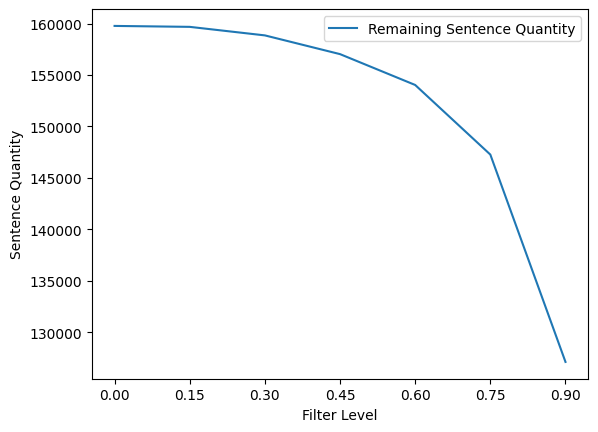

In [28]:
import matplotlib.pyplot as plt
result={}
for i in np.arange(0,1,0.15):
    result[f"{i:.2f}"]=0
    infp=Data_to_Analyze(type='infp',source=raw_data)
    infp.remove_mention_and_tag()
    infp.remove_emoji()
    infp.remove_url()
    infp.remove_whitespace()
    infp.drop_non_english(i)
    for j in infp.data.index:
        result[f"{i:.2f}"]+=len(infp.data.loc[j,"posts"])
result=pd.Series(result)
plt.plot(result.index,result.values,label="Remaining Sentence Quantity")
plt.xlabel("Filter Level")
plt.ylabel("Sentence Quantity")
plt.legend()
plt.show()

Finally, we choose filter level at 0.75, which means if the confidence level of the model>0.75, the sentence remains.

And for short sentence (consists of less that 6 words), we directly keep it since the model is not reliable to detect language of such short sentence.

### Construct data clean pipeline 

Since we need to **customize stopword** in order to enhance LDA model coherence, we divide data cleaning pipeline into two phrases to **save time**

Firstly, we will do all the cleaning process **without stopwords removal** and save the variables in pickle files. When optimizing LDA model, we **will not repeat this phrase**.

In [16]:
def analyze_data_p1(TYPE):
    data=Data_to_Analyze(type=TYPE,source=raw_data)
    data.remove_url()
    data.remove_mention_and_tag()

    # Some features like text readability need to be collected BEFORE the following cleaning procedures
    # Otherwise, they are NOT accurate
    data.get_sentence_quantity()
    data.get_word_count()
    data.get_upper_ratio()
    data.get_readability()
    data.get_vader_score()

    # Continue to clean the data
    data.remove_emoji()
    data.remove_whitespace()
    data.drop_non_english(0.75)
    data.expand_contractions()
    data.tolower()
    data.remove_punct()
    data.remove_whitespace()
    data.totokens()
    data.post_lemmatize()
    
    with open(f"Data\\cleaned_data\\p1\\{TYPE}_cleaned.pkl","wb") as f:
        pickle.dump(data,f)

# Analyze posts from all MBTI types

for T in tqdm(MBTI_types):
    analyze_data_p1(T)

  0%|          | 0/16 [00:00<?, ?it/s]

#### Add custom stopwords

In phrase 2, we will load custom stopwords from external `json` file and load cleaned data after **phrase 1** from `pickle` file.

The stopwords will be updated every time after training an LDA model. We will **repeat the loop**: *remove stopwords->train LDA model->update stopwords->remove stopwords...* **until LDA result is good enough**.

In [7]:
# Load custom stopwords
with open("custom_stopwords.json","r") as f:
    custom_stopwords=json.load(f)
stop_words.update(custom_stopwords)
stop_words

{'dk',
 'decide',
 'je',
 'ne',
 'nga',
 'ww',
 'lmfao',
 'up',
 'actually',
 'ours',
 'anyhow',
 'meeee',
 'usual',
 'look',
 'tuesday',
 'somewhat',
 'nicely',
 'hate',
 'her',
 'itself',
 'opinion',
 'thread',
 'thank',
 'hmmm',
 'peo',
 'therefore',
 'return',
 'rly',
 'both',
 'many',
 'whose',
 'priv',
 'specifically',
 'night',
 'less',
 'pu',
 'perfect',
 'our',
 'hers',
 'youu',
 'against',
 'truly',
 'omgg',
 'yo',
 'hear',
 'near',
 'for',
 'long',
 'hehehehe',
 'thus',
 'tangina',
 'sorry',
 'mt',
 'various',
 'here',
 'ko',
 'hahahahahah',
 'plan',
 'kr',
 'never',
 'eleven',
 'practically',
 'self',
 'nd',
 'take',
 'x',
 'l',
 'nowhere',
 'done',
 'perhaps',
 'wala',
 'yayyy',
 'some',
 'sana',
 'si',
 'sh',
 'permanently',
 'whe',
 'everyone',
 'over',
 'yourselves',
 'ilysm',
 'hindi',
 'mga',
 'generally',
 'omgggg',
 'val',
 'basically',
 'intentionally',
 'hehehe',
 'me',
 'mar',
 'yours',
 'herein',
 'wo',
 'where',
 'off',
 'love',
 'aha',
 'ck',
 'ie',
 'hap',
 '

In [8]:
# Check the number of stopwords
len(stop_words)

1082

In [9]:
# Remove stopwords
def analyze_data_p2(TYPE):
    with open(f"Data/cleaned_data/p1/{TYPE}_cleaned.pkl",'rb') as f:
        data=pickle.load(f)
    data.remove_stopwords()
    data.concatenate_post()
    with open(f"Data/cleaned_data/{TYPE}_cleaned.pkl","wb") as f:
        pickle.dump(data,f)
for T in tqdm(MBTI_types):
    analyze_data_p2(T)

  0%|          | 0/16 [00:00<?, ?it/s]

#### Demonstration of each step

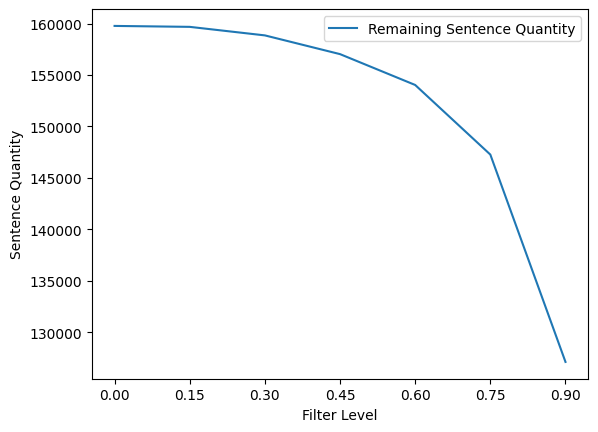

In [26]:
infp=Data_to_Analyze('infp')
infp.remove_url()
infp.remove_mention_and_tag()
infp.remove_emoji()
infp.remove_whitespace()
infp.remove_punct()
test=infp.data.loc[0,"posts"]

In [27]:
ans=0
for sentence in test:
    ans+=len(sentence.split(" "))
ans

3314

In [39]:
infp.drop_non_english(0.75)
infp.data.head(30)

,posts,type
0,"[ Thanks Forest!, Thank you., Thanks!, Than...",infp
1,"[ Submission was made with the name ""The Match...",infp
2,"[the only acceptable minion meme , if u say n...",infp
3,"[NO FUCKING WAY? , SCREMSING AND CRYING , SAY...",infp
4,"[when ur mom says u lost weight , i am insane ...",infp
5,"[I’m on guys, Why do people keep following thi...",infp
6,[Yea the drake album took me straight to the b...,infp
7,[Threads have been made about this chick on /b...,infp
8,[one person followed me and 2 people unfollowe...,infp
9,"[who wants to be my comfie, nerd, isn’t she ...",infp


In [40]:
infp.expand_contractions()
infp.data.head(30)

,posts,type
0,"[Thanks Forest!, Thank you., Thanks!, Thank yo...",infp
1,"[Submission was made with the name ""The Matchs...",infp
2,"[the only acceptable minion meme, if you say ...",infp
3,"[NO FUCKING WAY?, SCREMSING AND CRYING, SAYR C...",infp
4,"[when you are mom says you lost weight, i am...",infp
5,"[I am on guys, Why do people keep following ...",infp
6,[Yea the drake album took me straight to the b...,infp
7,[Threads have been made about this chick on /b...,infp
8,[one person followed me and 2 people unfollowe...,infp
9,"[who wants to be my comfie, nerd, is not she ...",infp


In [41]:
infp.tolower()
infp.data.head(30)


,posts,type
0,"[thanks forest!, thank you., thanks!, thank yo...",infp
1,"[submission was made with the name ""the matchs...",infp
2,"[the only acceptable minion meme, if you say ...",infp
3,"[no fucking way?, scremsing and crying, sayr c...",infp
4,"[when you are mom says you lost weight, i am...",infp
5,"[i am on guys, why do people keep following ...",infp
6,[yea the drake album took me straight to the b...,infp
7,[threads have been made about this chick on /b...,infp
8,[one person followed me and 2 people unfollowe...,infp
9,"[who wants to be my comfie, nerd, is not she ...",infp


In [42]:
infp.remove_punct()
infp.data.head(30)

,posts,type
0,"[thanks forest , thank you , thanks , thank yo...",infp
1,[submission was made with the name the matchs...,infp
2,"[the only acceptable minion meme, if you say ...",infp
3,"[no fucking way , scremsing and crying, sayr c...",infp
4,"[when you are mom says you lost weight, i am...",infp
5,"[i am on guys, why do people keep following ...",infp
6,[yea the drake album took me straight to the b...,infp
7,[threads have been made about this chick on b...,infp
8,[one person followed me and people unfollowe...,infp
9,"[who wants to be my comfie, nerd, is not she ...",infp


In [44]:
infp.totokens()
infp.data.head(30)

,posts,type
0,"[[thanks, forest], [thank, you], [thanks], [th...",infp
1,"[[submission, was, made, with, the, name, the,...",infp
2,"[[the, only, acceptable, minion, meme], [if, y...",infp
3,"[[no, fucking, way], [scremsing, and, crying],...",infp
4,"[[when, you, are, mom, says, you, lost, weight...",infp
5,"[[i, am, on, guys], [why, do, people, keep, fo...",infp
6,"[[yea, the, drake, album, took, me, straight, ...",infp
7,"[[threads, have, been, made, about, this, chic...",infp
8,"[[one, person, followed, me, and, people, unfo...",infp
9,"[[who, wants, to, be, my, comfie], [nerd], [is...",infp


In [46]:
infp.post_lemmatize()
infp.data.head(30)


,posts,type
0,"[[thanks, forest], [thank, you], [thanks], [th...",infp
1,"[[submission, be, make, with, the, name, the, ...",infp
2,"[[the, only, acceptable, minion, meme], [if, y...",infp
3,"[[no, fucking, way], [scremsing, and, cry], [s...",infp
4,"[[when, you, be, mom, say, you, lose, weight],...",infp
5,"[[i, be, on, guy], [why, do, people, keep, fol...",infp
6,"[[yea, the, drake, album, take, me, straight, ...",infp
7,"[[thread, have, be, make, about, this, chick, ...",infp
8,"[[one, person, follow, me, and, people, unfoll...",infp
9,"[[who, want, to, be, my, comfie], [nerd], [be,...",infp


In [47]:
infp.remove_stopwords()
infp.data.head(30)

,posts,type
0,"[[thanks, forest], [thank], [thanks], [thank, ...",infp
1,"[[submission, matchstickguy], [choose, matchst...",infp
2,"[[acceptable, minion, meme], [feel, free, way]...",infp
3,"[[fucking, way], [scremsing], [sayr, cute], [a...",infp
4,"[[weight], [], [worth, honest], [update, stres...",infp
5,"[[guy], [people, account], [felt, resonate, de...",infp
6,"[[drake, album, straight, beach, hand], [tweet...",infp
7,"[[chick, biz, year], [incels, relate], [hop, t...",infp
8,"[[person, people], [people, person], [help, ba...",infp
9,"[[want, comfie], [nerd], [junior], [laugh, wha...",infp


In [48]:
infp.drop_empty()
infp.data.head(30)

,posts,type
0,"[[thanks, forest], [thank], [thanks], [thank, ...",infp
1,"[[submission, matchstickguy], [choose, matchst...",infp
2,"[[acceptable, minion, meme], [feel, free, way]...",infp
3,"[[fucking, way], [scremsing], [sayr, cute], [a...",infp
4,"[[weight], [worth, honest], [update, stress, r...",infp
5,"[[guy], [people, account], [felt, resonate, de...",infp
6,"[[drake, album, straight, beach, hand], [tweet...",infp
7,"[[chick, biz, year], [incels, relate], [hop, t...",infp
8,"[[person, people], [people, person], [help, ba...",infp
9,"[[want, comfie], [nerd], [junior], [laugh, wha...",infp


### Consider adding a new dataset

In [25]:
extra_data=pd.read_csv("Data\MBTI_500.csv",encoding='utf-8')
extra_data

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\DominicMin\AppData\Local\Temp\ipykernel_29000\249695874.py:1: SyntaxWarning: invalid escape sequence '\M'
  extra_data=pd.read_csv("Data\MBTI_500.csv",encoding='utf-8')


,Unnamed: 0,posts,type
0,0,know intj tool use interaction people excuse a...,intj
1,1,rap music ehh opp yeah know valid well know fa...,intj
2,2,preferably p hd low except wew lad video p min...,intj
3,3,drink like wish could drink red wine give head...,intj
4,4,space program ah bad deal meing freelance max ...,intj
...,...,...,...
106062,106062,stay frustrate world life want take long nap w...,infp
106063,106063,fizzle around time mention sure mistake thing ...,infp
106064,106064,schedule modify hey w intp strong wing underst...,infp
106065,106065,enfj since january busy schedule able spend li...,infp


In [27]:
extra_data['posts']=extra_data['posts'].apply(lambda x:x.split())

In [34]:
test=extra_data.loc[0,'posts']
test

['know',
 'intj',
 'tool',
 'use',
 'interaction',
 'people',
 'excuse',
 'antisocial',
 'truly',
 'enlighten',
 'mastermind',
 'know',
 'would',
 'count',
 'pet',
 'peeze',
 'something',
 'time',
 'matter',
 'people',
 'either',
 'whether',
 'group',
 'people',
 'mall',
 'never',
 'see',
 'best',
 'friend',
 'sit',
 'outside',
 'conversation',
 'jsut',
 'listen',
 'want',
 'interject',
 'sit',
 'formulate',
 'say',
 'wait',
 'inject',
 'argument',
 'thought',
 'find',
 'fascinate',
 'sit',
 'watch',
 'people',
 'talk',
 'people',
 'fascinate',
 'sit',
 'class',
 'watch',
 'different',
 'people',
 'find',
 'intrigue',
 'dad',
 'intj',
 'u',
 'stand',
 'look',
 'like',
 'line',
 'safeway',
 'watch',
 'people',
 'home',
 'talk',
 'people',
 'like',
 'think',
 'military',
 'job',
 'people',
 'voluntarily',
 'go',
 'job',
 'important',
 'show',
 'deference',
 'endanger',
 'live',
 'glorify',
 'way',
 'civilian',
 'think',
 'pretty',
 'ignorant',
 'general',
 'think',
 'military',
 'necessa

In [47]:
for T in tqdm(MBTI_types):
    data=Data_to_Analyze(type=T,source=extra_data)
    data.remove_stopwords()
    with open(f'Data/cleaned_data/extra/{T}_extra.pkl','wb') as f:
        pickle.dump(data,f)

  0%|          | 0/16 [00:00<?, ?it/s]